## Location-Aware Real Estate Price & Recommendation Engine

In [1]:
import pandas as pd
import numpy as np

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("./Dataset/gurgaon_10k.csv")
print("Initial shape:", df.shape)

selected_cols = [
    'PREFERENCE', 'DESCRIPTION', 'PROPERTY_TYPE', 'CITY', 'LOCALITY', 'TRANSACT_TYPE', 'OWNTYPE',
    'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'PRICE_PER_UNIT_AREA', 'FURNISH', 'FACING', 'AGE',
    'FLOOR_NUM', 'TOTAL_FLOOR', 'FEATURES', 'SUPERBUILTUP_SQFT', 'AMENITIES', 'TOTAL_LANDMARK_COUNT',
    'CONTACT_NAME', 'SOCIETY_NAME', 'CITY_ID', 'location', 'QUALITY_SCORE', 'MIN_PRICE', 'AREA'
]

df = df[selected_cols]

# -------------------------
# Convert to categorical
# -------------------------
df['FURNISH'] = df['FURNISH'].astype('category')
df['FACING'] = df['FACING'].astype('category')
df['PROPERTY_TYPE'] = df['PROPERTY_TYPE'].astype('category')
df['LOCALITY'] = df['LOCALITY'].astype('category')

# Save category mappings (to reuse later on test/new input)
furnish_categories = df['FURNISH'].cat.categories
facing_categories = df['FACING'].cat.categories
property_type_categories = df['PROPERTY_TYPE'].cat.categories
locality_categories = df['LOCALITY'].cat.categories

# -------------------------
# Clean numeric fields
# -------------------------
df['TRANSACT_TYPE'] = df['TRANSACT_TYPE'].fillna(0).astype(int)

df['AREA'] = df['AREA'].str.replace('sq.ft.', '', regex=False).str.strip()
df['AREA'] = pd.to_numeric(df['AREA'], errors='coerce')

# -------------------------
# Encode categorical as codes
# -------------------------
df['FURNISH_CODE'] = df['FURNISH'].cat.codes
df['FACING_CODE'] = df['FACING'].cat.codes
df['PROPERTY_TYPE_CODE'] = df['PROPERTY_TYPE'].cat.codes
df['LOCALITY_CODE'] = df['LOCALITY'].cat.codes

# -------------------------
# Target variable
# -------------------------
df['TARGET_PRICE'] = df['MIN_PRICE']

print("Final shape (no filters):", df.shape)

# Save mappings for later verification
property_type_mapping = dict(enumerate(df['PROPERTY_TYPE'].cat.categories))
locality_mapping = dict(enumerate(df['LOCALITY'].cat.categories))
furnish_mapping = dict(enumerate(df['FURNISH'].cat.categories))
facing_mapping = dict(enumerate(df['FACING'].cat.categories))

print("\nCategory Mappings:")
print("PROPERTY_TYPE:", property_type_mapping)
print("LOCALITY:", {k: v for k, v in list(locality_mapping.items())[:10]})  # print first 10 only
print("FURNISH:", furnish_mapping)
print("FACING:", facing_mapping)



Initial shape: (10704, 67)
Final shape (no filters): (10704, 32)

Category Mappings:
PROPERTY_TYPE: {0: 'Independent House/Villa', 1: 'Independent/Builder Floor', 2: 'Residential Apartment', 3: 'Residential Land'}
LOCALITY: {0: 'A Block Sushant Lok Phase - 3', 1: 'A Block Sushant Lok Phase 1', 2: 'Ambience', 3: 'Ansal Plaza', 4: 'Ardee City', 5: 'Ashok Vihar Phase 1', 6: 'B Block Sushant Lok Phase 1', 7: 'Badshahpur', 8: 'Bhondsi', 9: 'Bissar'}
FURNISH: {0: 0, 1: 1, 2: 2, 3: 4}
FACING: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


C:\Users\Sarvesh Ram Kumar\AppData\Local\Temp\ipykernel_32316\1136119044.py:7: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Dataset/gurgaon_10k.csv")


In [2]:
import json

# Save as lists (since cat.categories is a CategoricalIndex)
mappings = {
    "furnish": df['FURNISH'].cat.categories.tolist(),
    "facing": df['FACING'].cat.categories.tolist(),
    "property_type": df['PROPERTY_TYPE'].cat.categories.tolist(),
    "locality": df['LOCALITY'].cat.categories.tolist()
}

with open("category_mappings.json", "w") as f:
    json.dump(mappings, f, indent=4)

In [3]:
# Replace 'G' with 0
df['FLOOR_NUM'] = df['FLOOR_NUM'].replace('G', 0)

# Convert to numeric and fill NaNs with -1 (explicitly "not applicable")
df['FLOOR_NUM'] = pd.to_numeric(df['FLOOR_NUM'], errors='coerce').fillna(-1).astype(int)
FEATURE_SCORE_MAP = {
    1: 5,   # Swimming Pool
    2: 4,   # Power Backup
    3: 4,   # Club house
    4: 3,   # Parking
    6: 2,   # Park
    9: 4,   # Security Personnel
    11: 1,  # ATM
    12: 4,  # Gymnasium
    21: 3,  # Lift
    25: 2,  # Waste disposal
    29: 3,  # Gas Pipeline
    34: 3,  # Wheelchair Accessibility
    35: 2,  # DG Availability
    39: 1   # Near bank
}
def score_features(feature_str):
    if pd.isna(feature_str):
        return 0
    ids = [int(i.strip()) for i in feature_str.split(',') if i.strip().isdigit()]
    return sum(FEATURE_SCORE_MAP.get(i, 0) for i in ids)

df['FEATURE_SCORE'] = df['FEATURES'].apply(score_features)

AMENITY_SCORE_MAP = {
    1: 18,   # Swimming Pool
    2: 10,   # Power Back-up
    3: 5,   # Club house / Community Center
    5: 4,   # Feng Shui / Vaastu Compliant
    6: 15,   # Park
    8: 15,   # Private Garden / Terrace
    9: 13,   # Security Personnel
    10: 17,  # Centrally Air Conditioned
    11: 5,  # ATM
    12: 10,  # Fitness Centre / GYM
    13: 15,  # Cafeteria / Food Court
    15: 15,  # Bar / Lounge
    16: 10,  # Conference room
    17: 17,  # Security / Fire Alarm
    19: 5,  # Visitor Parking
    20: 5,  # Intercom Facility
    21: 4,  # Lift(s)
    22: 5,  # Service / Goods Lift
    23: 5,  # Maintenance Staff
    24: 10,  # Water Storage
    25: 15,  # Waste Disposal
    26: 5,  # Rain Water Harvesting
    27: 17,  # Access to High Speed Internet
    28: 10,  # Bank Attached Property
    29: 10,  # Piped-gas
    32: 10,  # Water purifier
    33: 15,  # Shopping Centre
    34: 5,  # WheelChair Accessibilitiy
    35: 5,  # DG Availability
    36: 15,  # CCTV Surveillance
    37: 15,  # Grade A Building
    38: 15,  # Grocery Shop
    39: 5   # Near Bank
}

def score_amenities(amenity_str):
    if pd.isna(amenity_str):
        return 0
    ids = [int(i.strip()) for i in amenity_str.split(',') if i.strip().isdigit()]
    return sum(AMENITY_SCORE_MAP.get(i, 0) for i in ids)

df['AMENITY_SCORE'] = df['AMENITIES'].apply(score_amenities)


In [4]:
FURNISH_MAP = {
    "furnished": 1,
    "unfurnished": 2,
    "semi-furnished": 4,
    "semifurnished": 4   # allow both with/without hyphen
}

# Facing mapping dictionary (case-insensitive, flexible input)
FACING_MAP = {
    "north": 1,
    "south": 2,
    "east": 3,
    "west": 4,
    "north-east": 5,
    "northeast": 5,
    "ne": 5,
    "north-west": 6,
    "northwest": 6,
    "nw": 6,
    "south-east": 7,
    "southeast": 7,
    "se": 7,
    "south-west": 8,
    "southwest": 8,
    "sw": 8
}


# -------------------------
# Function to preprocess new input with SAME categories
# -------------------------
def preprocess_input(raw_input):
    input_df = pd.DataFrame([raw_input])

    if 'FURNISH' in input_df.columns:
        furnish_val = str(input_df.at[0, 'FURNISH']).lower().strip()
        if furnish_val in FURNISH_MAP:
            input_df.at[0, 'FURNISH'] = FURNISH_MAP[furnish_val]
        else:
            raise ValueError(f"❌ Unknown FURNISH value: {furnish_val}. Expected one of {list(FURNISH_MAP.keys())}")
        
    if 'FACING' in input_df.columns:
        facing_val = str(input_df.at[0, 'FACING']).lower().strip()
        if facing_val in FACING_MAP:
            input_df.at[0, 'FACING'] = FACING_MAP[facing_val]
        else:
            raise ValueError(f"❌ Unknown FACING value: {facing_val}. Expected one of {list(FACING_MAP.keys())}")

    # Apply same categories as training
    input_df['FURNISH'] = input_df['FURNISH'].astype(pd.CategoricalDtype(categories=furnish_categories))
    input_df['FACING'] = input_df['FACING'].astype(pd.CategoricalDtype(categories=facing_categories))
    input_df['PROPERTY_TYPE'] = input_df['PROPERTY_TYPE'].astype(pd.CategoricalDtype(categories=property_type_categories))
    input_df['LOCALITY'] = input_df['LOCALITY'].astype(pd.CategoricalDtype(categories=locality_categories))

    # Clean AREA
    if 'AREA' in input_df:
        input_df['AREA'] = input_df['AREA'].astype(str).str.replace('sq.ft.', '', regex=False).str.strip()
        input_df['AREA'] = pd.to_numeric(input_df['AREA'], errors='coerce')

    # Encode categorical using same mapping
    input_df['FURNISH_CODE'] = input_df['FURNISH'].cat.codes
    input_df['FACING_CODE'] = input_df['FACING'].cat.codes
    input_df['PROPERTY_TYPE_CODE'] = input_df['PROPERTY_TYPE'].cat.codes
    input_df['LOCALITY_CODE'] = input_df['LOCALITY'].cat.codes

    # Handle TRANSACT_TYPE
    if 'TRANSACT_TYPE' in input_df:
        input_df['TRANSACT_TYPE'] = input_df['TRANSACT_TYPE'].fillna(0).astype(int)

    # Handle FLOOR_NUM (replace 'G' with 0, NaNs → -1)
    if 'FLOOR_NUM' in input_df:
        input_df['FLOOR_NUM'] = input_df['FLOOR_NUM'].replace('G', 0)
        input_df['FLOOR_NUM'] = pd.to_numeric(input_df['FLOOR_NUM'], errors='coerce').fillna(-1).astype(int)

    # Feature Score
    def score_features(feature_str):
        if pd.isna(feature_str):
            return 0
        ids = [int(i.strip()) for i in str(feature_str).split(',') if i.strip().isdigit()]
        return sum(FEATURE_SCORE_MAP.get(i, 0) for i in ids)

    if 'FEATURES' in input_df:
        input_df['FEATURE_SCORE'] = input_df['FEATURES'].apply(score_features)

    # Amenity Score
    def score_amenities(amenity_str):
        if pd.isna(amenity_str):
            return 0
        ids = [int(i.strip()) for i in str(amenity_str).split(',') if i.strip().isdigit()]
        return sum(AMENITY_SCORE_MAP.get(i, 0) for i in ids)

    if 'AMENITIES' in input_df:
        input_df['AMENITY_SCORE'] = input_df['AMENITIES'].apply(score_amenities)

    # Debug print
    print("\n🔎 Input Encoding Verification:")
    print("PROPERTY_TYPE:", input_df['PROPERTY_TYPE'].iloc[0], "->", input_df['PROPERTY_TYPE_CODE'].iloc[0])
    print("LOCALITY:", input_df['LOCALITY'].iloc[0], "->", input_df['LOCALITY_CODE'].iloc[0])
    print("FURNISH:", input_df['FURNISH'].iloc[0], "->", input_df['FURNISH_CODE'].iloc[0])
    print("FACING:", input_df['FACING'].iloc[0], "->", input_df['FACING_CODE'].iloc[0])

    return input_df


In [5]:
print("Final shape:", df.shape)

# ✅ save processed dataset for later use in Django
df.to_csv("processed_data.csv", index=False)
print("✅ Processed dataset saved as processed_data.csv")

Final shape: (10704, 34)
✅ Processed dataset saved as processed_data.csv


In [6]:
print("Column datatypes from first row:\n")
first_row = df.iloc[0]

for col in df.columns:
    print(f"{col}: {type(first_row[col])}")


Column datatypes from first row:

PREFERENCE: <class 'str'>
DESCRIPTION: <class 'str'>
PROPERTY_TYPE: <class 'str'>
CITY: <class 'str'>
LOCALITY: <class 'str'>
TRANSACT_TYPE: <class 'numpy.int64'>
OWNTYPE: <class 'numpy.int64'>
BEDROOM_NUM: <class 'numpy.float64'>
BATHROOM_NUM: <class 'numpy.int64'>
BALCONY_NUM: <class 'numpy.float64'>
PRICE_PER_UNIT_AREA: <class 'numpy.float64'>
FURNISH: <class 'numpy.int64'>
FACING: <class 'numpy.int64'>
AGE: <class 'numpy.int64'>
FLOOR_NUM: <class 'numpy.int64'>
TOTAL_FLOOR: <class 'numpy.float64'>
FEATURES: <class 'str'>
SUPERBUILTUP_SQFT: <class 'numpy.float64'>
AMENITIES: <class 'str'>
TOTAL_LANDMARK_COUNT: <class 'numpy.float64'>
CONTACT_NAME: <class 'str'>
SOCIETY_NAME: <class 'str'>
CITY_ID: <class 'numpy.int64'>
location: <class 'str'>
QUALITY_SCORE: <class 'numpy.float64'>
MIN_PRICE: <class 'numpy.int64'>
AREA: <class 'numpy.float64'>
FURNISH_CODE: <class 'numpy.int8'>
FACING_CODE: <class 'numpy.int8'>
PROPERTY_TYPE_CODE: <class 'numpy.int8'

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Setup
# -------------------------
ml_features = [
    'PROPERTY_TYPE_CODE', 'LOCALITY_CODE', 'TRANSACT_TYPE', 'OWNTYPE', 'AGE',
    'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA', 'FURNISH_CODE','FACING_CODE',
    'FLOOR_NUM', 'TOTAL_FLOOR', 'TOTAL_LANDMARK_COUNT',
    'QUALITY_SCORE', 'CITY_ID', 'FEATURE_SCORE', 'AMENITY_SCORE'
]

# Prepare features and target
X = df[ml_features].copy().fillna(0)
y = df['TARGET_PRICE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
epsilon = 1e-10
y_test_np = y_test.to_numpy()

# -------------------------
# Evaluation (Full Set)
# -------------------------
mae = mean_absolute_error(y_test_np, y_pred)
mse = mean_squared_error(y_test_np, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred)
rel_errors = np.abs((y_test_np - y_pred) / (y_test_np + epsilon))

mape = np.mean(rel_errors) * 100
mdape = np.median(rel_errors) * 100
smape = 100 * np.mean(2 * np.abs(y_test_np - y_pred) / (np.abs(y_test_np) + np.abs(y_pred) + epsilon))

# Accuracy within tolerances
within_10 = np.mean(rel_errors <= 0.10) * 100
within_20 = np.mean(rel_errors <= 0.20) * 100
within_30 = np.mean(rel_errors <= 0.30) * 100

print("\n🔍 Model Evaluation (Full Set):")
print(f"MAE:   ₹{mae:,.2f}")
print(f"MSE:   ₹{mse:,.2f}")
print(f"RMSE:  ₹{rmse:,.2f}")
print(f"R²:    {r2:.4f}")

print("\n📊 Relative Error Metrics:")
print(f"MAPE:  {mape:.2f}%")
print(f"MdAPE: {mdape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"±10%: {within_10:.2f}%")
print(f"±20%: {within_20:.2f}%")
print(f"±30%: {within_30:.2f}%")

# -------------------------
# Save full predictions
# -------------------------
results_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred
})
results_df['ABS_ERROR'] = np.abs(results_df['Actual Price'] - results_df['Predicted Price'])
results_df['REL_ERROR'] = np.abs(results_df['ABS_ERROR'] / (results_df['Actual Price'] + epsilon))
results_df = results_df.round(2)
results_df.to_excel("actual_vs_predicted_full.xlsx", index=False)

# -------------------------
# Filtered Evaluation (Actual ≥ ₹1L & REL_ERROR ≤ 99th percentile)
# -------------------------
quantile_99 = results_df['REL_ERROR'].quantile(0.99)
filtered_df = results_df[
    (results_df['Actual Price'] >= 100000) &
    (results_df['REL_ERROR'] <= quantile_99)
]

filtered_mape = filtered_df['REL_ERROR'].mean() * 100
filtered_mdape = filtered_df['REL_ERROR'].median() * 100
filtered_smape = 100 * np.mean(
    2 * np.abs(filtered_df['Actual Price'] - filtered_df['Predicted Price']) /
    (np.abs(filtered_df['Actual Price']) + np.abs(filtered_df['Predicted Price']) + epsilon)
)

print("\n📊 Filtered (Actual ≥ ₹1L & REL_ERROR ≤ 99% quantile):")
print(f"Filtered MAPE:  {filtered_mape:.2f}%")
print(f"Filtered MdAPE: {filtered_mdape:.2f}%")
print(f"Filtered SMAPE: {filtered_smape:.2f}%")

# -------------------------
# Show Top Relative Errors
# -------------------------
top_errors = results_df.sort_values(by='REL_ERROR', ascending=False).head(10)
print("\n🚨 Top 10 Highest Relative Errors:")
print(top_errors[['Actual Price', 'Predicted Price', 'REL_ERROR']])

# -------------------------
# Save filtered results
# -------------------------
filtered_df.to_excel("actual_vs_predicted_filtered_two.xlsx", index=False)
print("\n📁 Results saved: full → 'actual_vs_predicted_full.xlsx', filtered → 'actual_vs_predicted_filtered.xlsx'")



🔍 Model Evaluation (Full Set):
MAE:   ₹5,941,548.07
MSE:   ₹344,816,888,207,759.25
RMSE:  ₹18,569,245.76
R²:    0.7734

📊 Relative Error Metrics:
MAPE:  196956621205044480.00%
MdAPE: 8.68%
SMAPE: 17.57%
±10%: 54.83%
±20%: 74.64%
±30%: 83.61%

📊 Filtered (Actual ≥ ₹1L & REL_ERROR ≤ 99% quantile):
Filtered MAPE:  19.17%
Filtered MdAPE: 8.00%
Filtered SMAPE: 15.58%

🚨 Top 10 Highest Relative Errors:
      Actual Price  Predicted Price     REL_ERROR
1804             0     3.558125e+08  3.558125e+18
1085             0     6.587163e+07  6.587163e+17
227         125000     5.242581e+07  4.184100e+02
1426        110000     3.715512e+07  3.367700e+02
1378        149000     1.579421e+07  1.050000e+02
1120        160000     1.550505e+07  9.591000e+01
813          35000     2.755906e+06  7.774000e+01
1383         90000     6.829070e+06  7.488000e+01
1550         65000     4.404240e+06  6.676000e+01
908         125000     7.131950e+06  5.606000e+01

📁 Results saved: full → 'actual_vs_predicted_ful

In [8]:
import joblib

# Save model
joblib.dump(model, "house_price_model.pkl")
print("✅ Model saved as house_price_model.pkl")

✅ Model saved as house_price_model.pkl


8                     AREA
13    TOTAL_LANDMARK_COUNT
6             BATHROOM_NUM
12             TOTAL_FLOOR
5              BEDROOM_NUM
1            LOCALITY_CODE
17           AMENITY_SCORE
16           FEATURE_SCORE
11               FLOOR_NUM
7              BALCONY_NUM
10             FACING_CODE
0       PROPERTY_TYPE_CODE
3                  OWNTYPE
4                      AGE
2            TRANSACT_TYPE
9             FURNISH_CODE
14           QUALITY_SCORE
15                 CITY_ID
Name: Feature, dtype: object 8     4.339401e-01
13    7.194171e-02
6     7.086280e-02
12    6.788385e-02
5     6.543338e-02
1     6.501902e-02
17    4.642853e-02
16    4.355787e-02
11    3.776290e-02
7     2.020766e-02
10    1.949907e-02
0     1.754443e-02
3     1.282844e-02
4     1.281715e-02
2     8.298835e-03
9     5.974104e-03
14    1.408595e-07
15    0.000000e+00
Name: Importance, dtype: float64


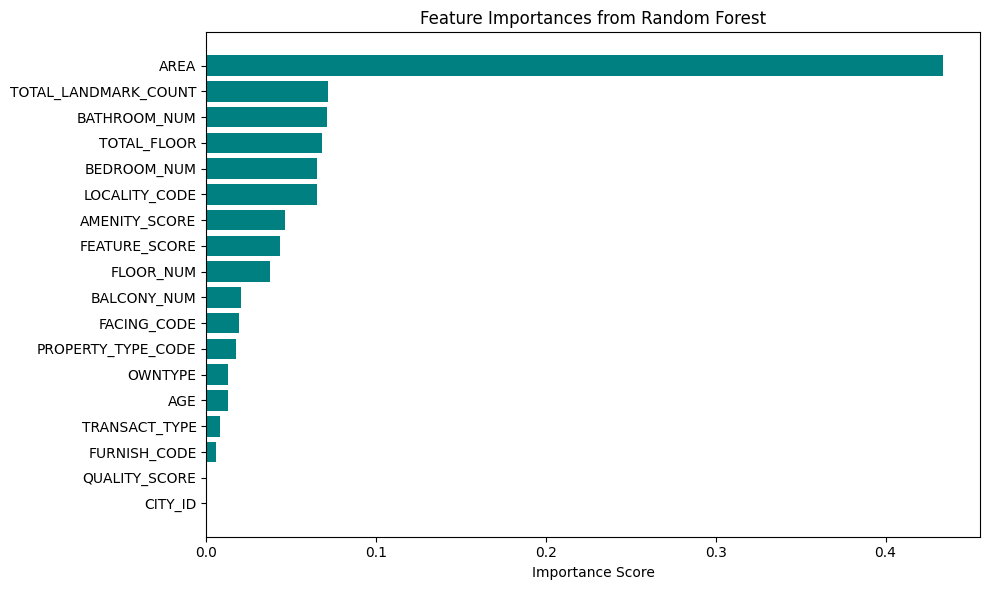

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming model is your trained RandomForestRegressor
importances = model.feature_importances_
feature_names = ml_features

# Create a DataFrame
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_df['Feature'], feature_df['Importance'])
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


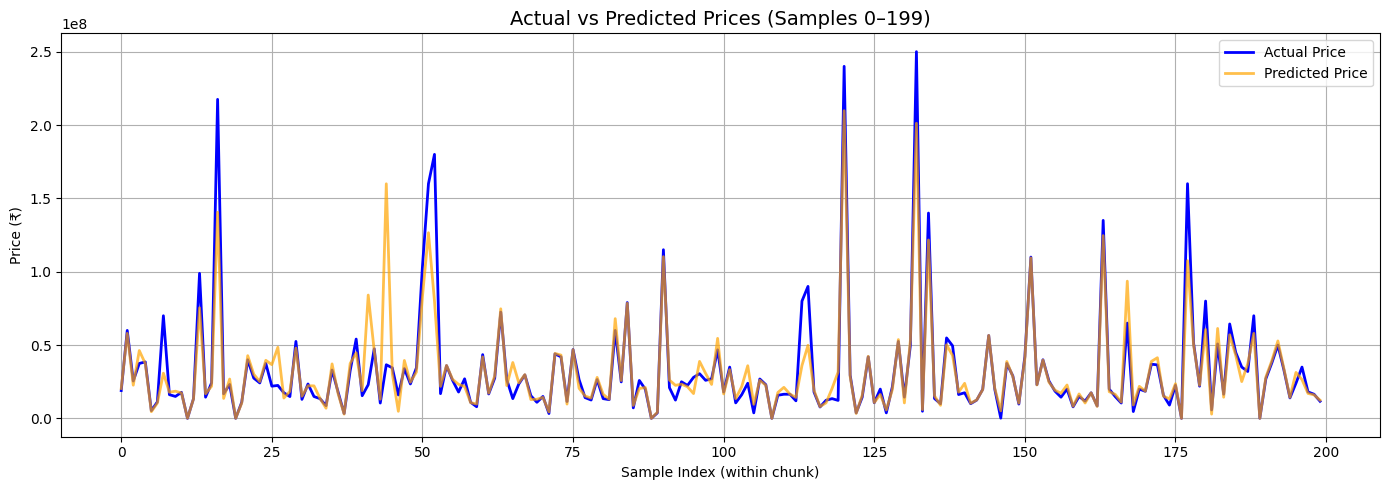

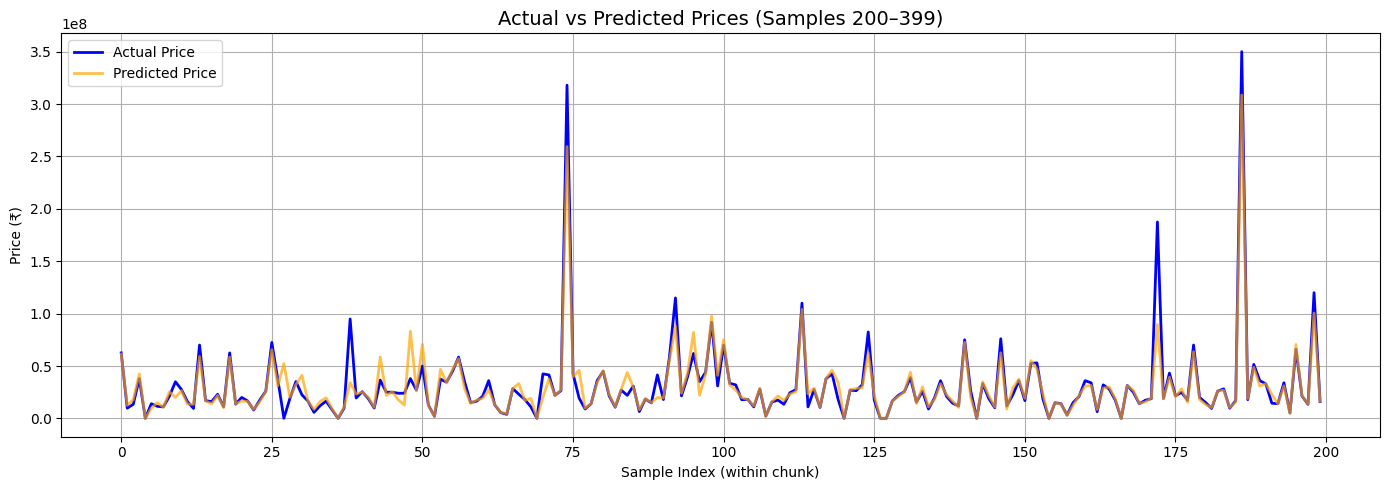

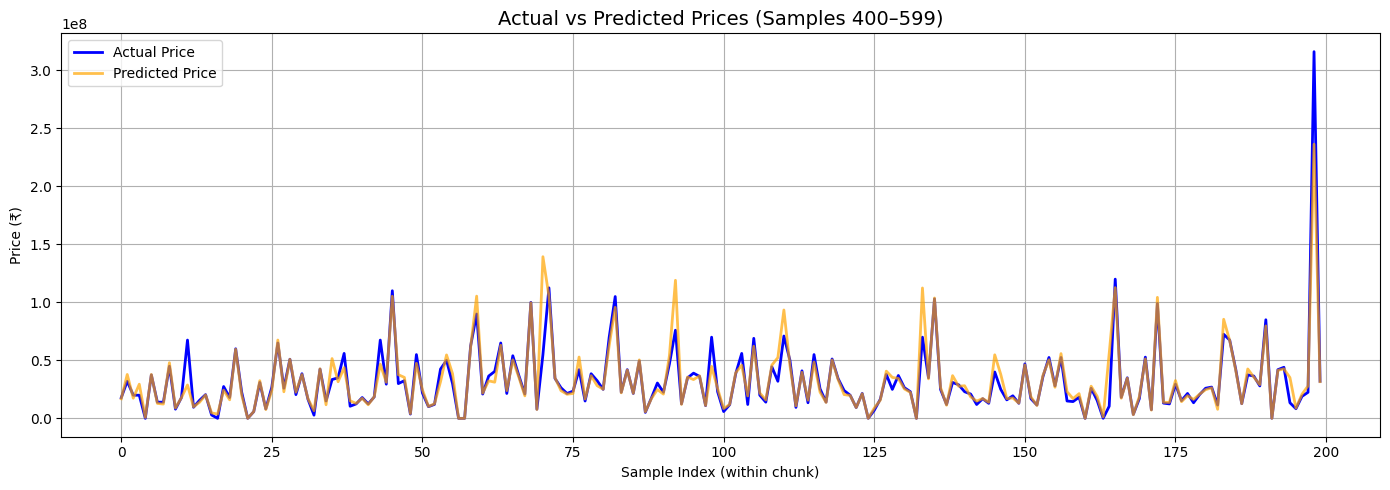

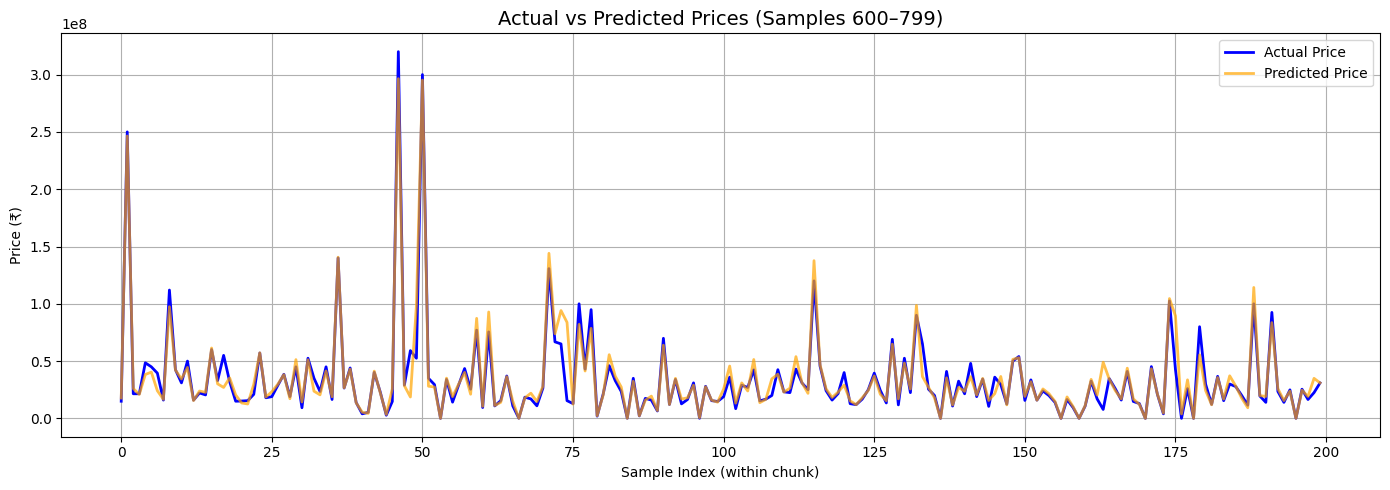

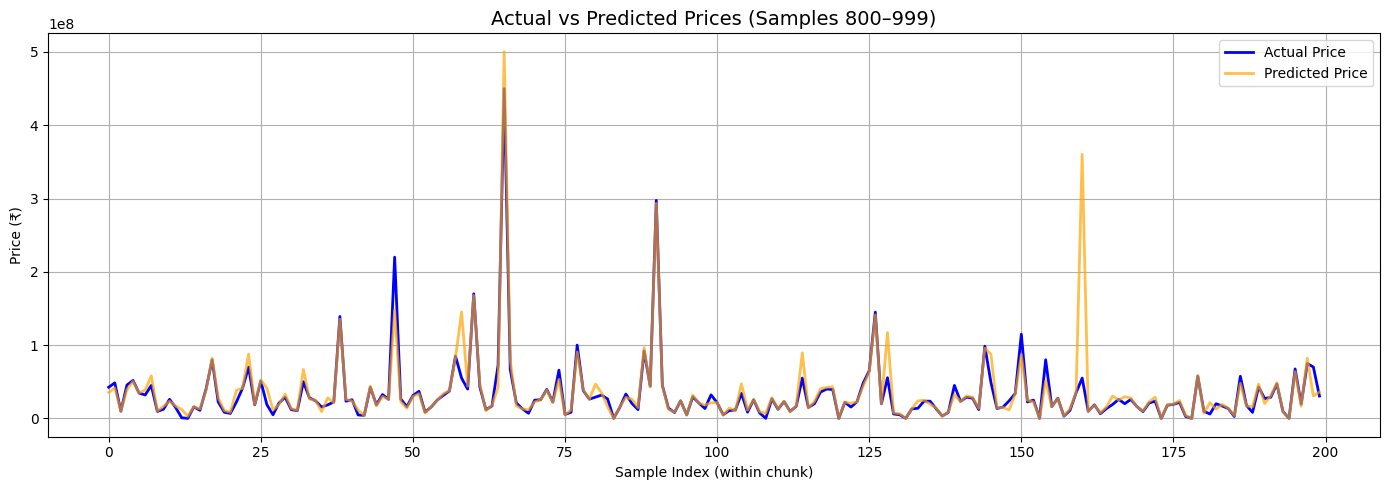

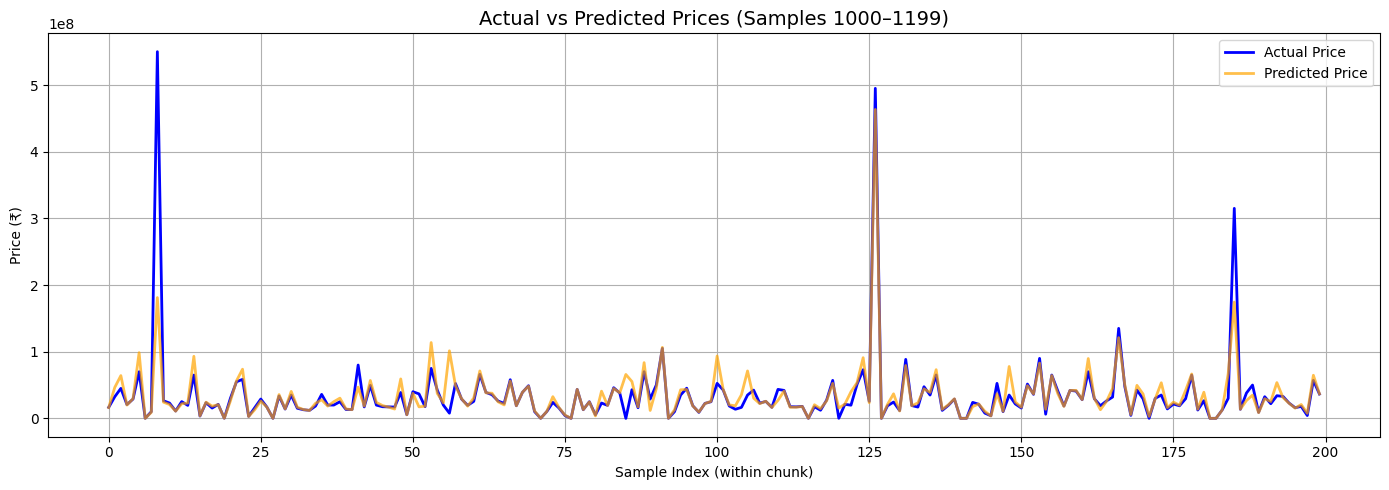

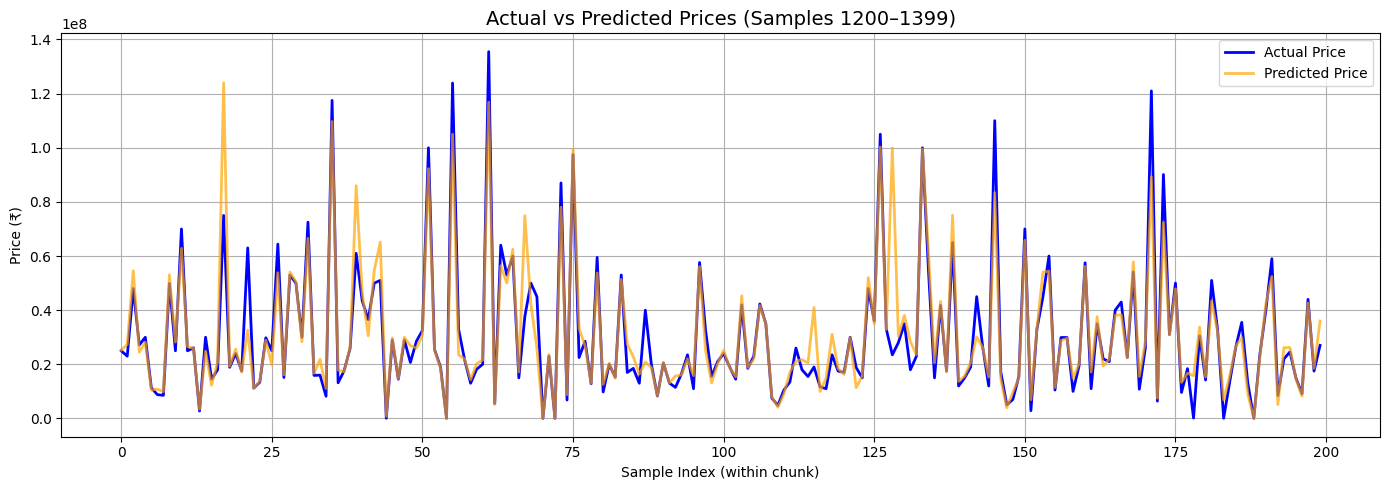

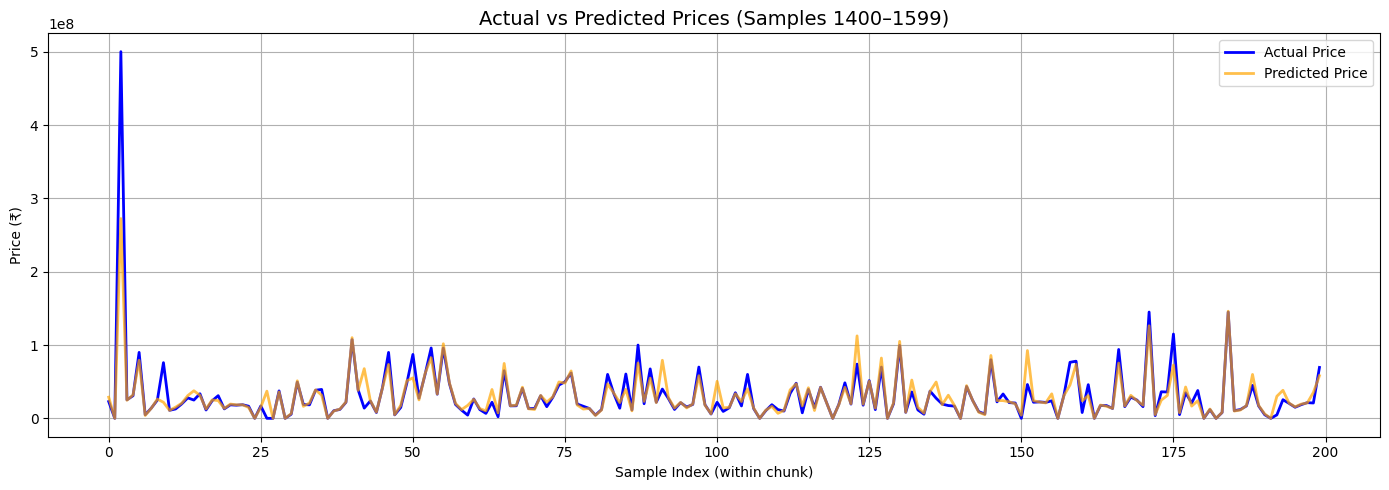

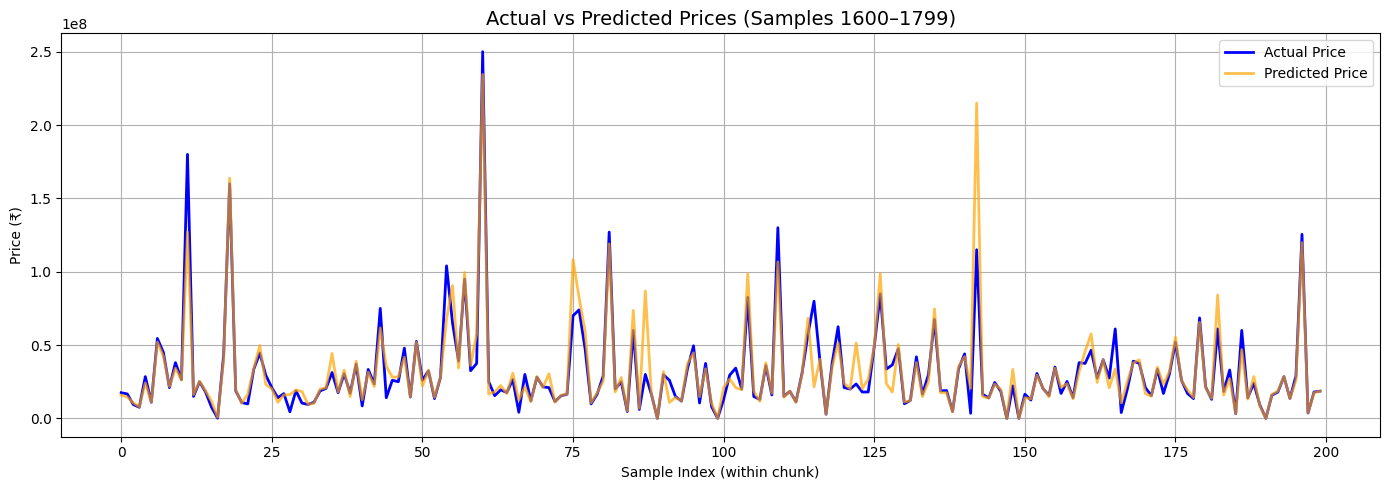

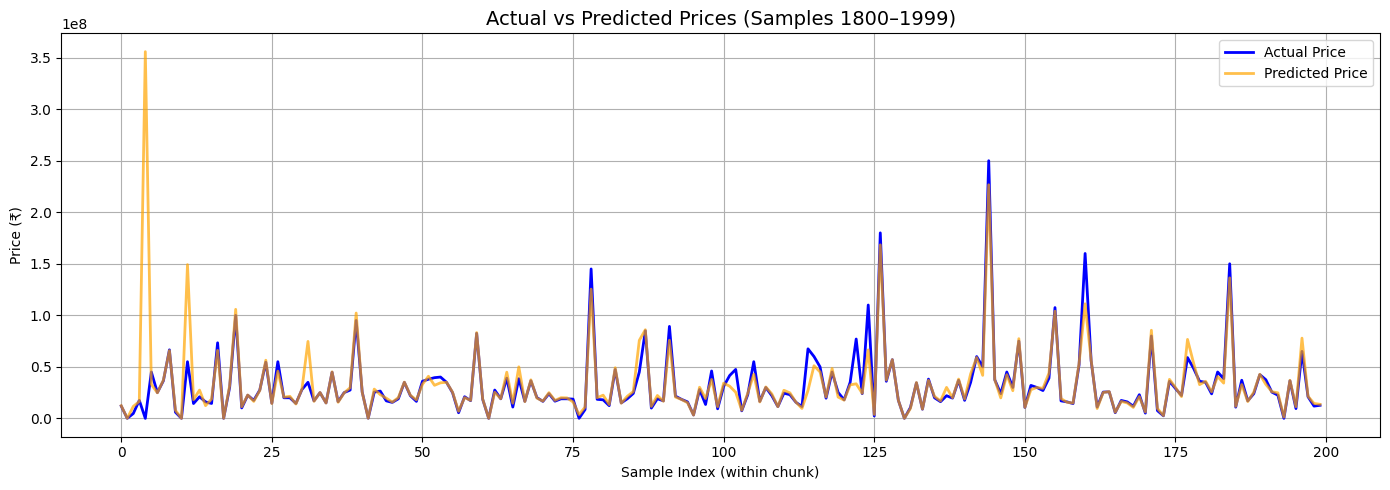

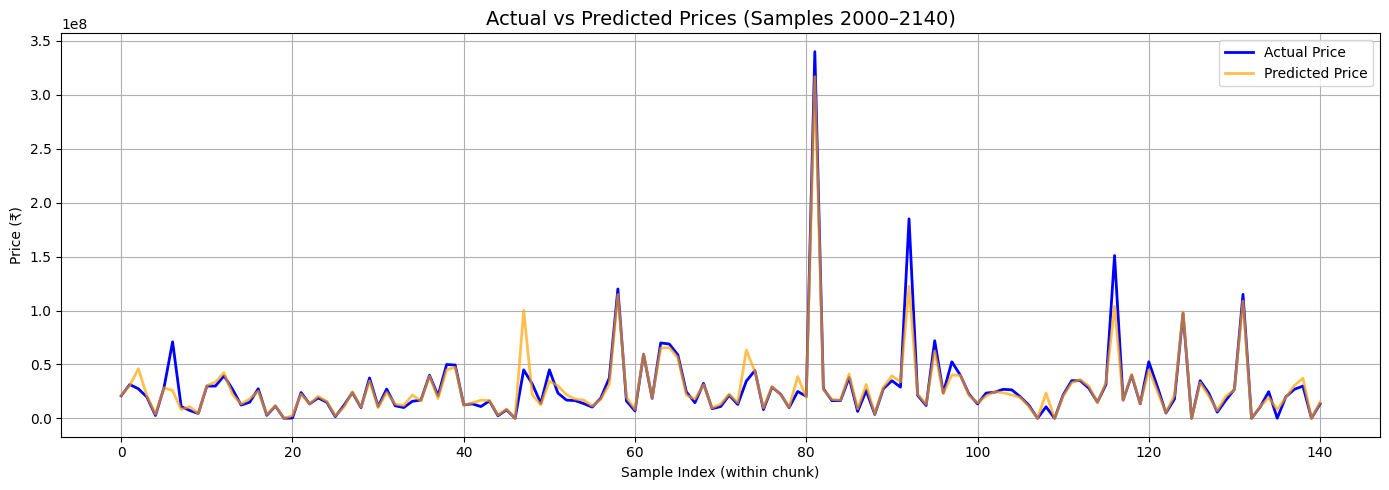

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert to aligned Series
y_actual = y_test.reset_index(drop=True)
y_predicted = pd.Series(y_pred, index=y_actual.index)

# Chunk size
chunk_size = 200
num_chunks = int(np.ceil(len(y_actual) / chunk_size))

# Plot each chunk
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(y_actual))

    plt.figure(figsize=(14, 5))
    plt.plot(y_actual[start:end].values, label='Actual Price', color='blue', linewidth=2)
    plt.plot(y_predicted[start:end].values, label='Predicted Price', color='orange', linewidth=2, alpha=0.7)
    plt.title(f'Actual vs Predicted Prices (Samples {start}–{end - 1})', fontsize=14)
    plt.xlabel('Sample Index (within chunk)')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [11]:
import numpy as np

# Ensure numpy arrays for math
y_actual = y_test.to_numpy()
y_predicted = y_pred

# 20% threshold check
tolerance = 0.20
within_tolerance = np.abs(y_predicted - y_actual) <= (tolerance * y_actual)

# Accuracy metric
tolerance_accuracy = np.mean(within_tolerance) * 100

print(f"\n✅ Prediction Accuracy (within ±20% of actual): {tolerance_accuracy:.2f}%")

# 30% threshold check
tolerance = 0.30
within_tolerance = np.abs(y_predicted - y_actual) <= (tolerance * y_actual)

# Accuracy metric
tolerance_accuracy = np.mean(within_tolerance) * 100

print(f"\n✅ Prediction Accuracy (within ±30% of actual): {tolerance_accuracy:.2f}%")



✅ Prediction Accuracy (within ±20% of actual): 74.64%

✅ Prediction Accuracy (within ±30% of actual): 83.61%


In [19]:
# --- Sample Input Dictionary ---
# Raw dictionary like a new row from CSV
raw_input = {
    'PREFERENCE': 'Buy',
    'DESCRIPTION': 'Spacious 3 BHK Apartment in a gated society',
    'PROPERTY_TYPE': 'Residential Apartment',
    'CITY': 'Gurgaon',
    'LOCALITY': 'Sector 84 Gurgaon',
    'TRANSACT_TYPE': 1,
    'OWNTYPE': 0,
    'BEDROOM_NUM': 4,
    'BATHROOM_NUM': 4,
    'BALCONY_NUM': 4,
    'PRICE_PER_UNIT_AREA': 8500,
    'FURNISH': 'semifurnished',
    'FACING': 'North',
    'AGE': 2,
    'FLOOR_NUM': 14,
    'TOTAL_FLOOR': 26,
    'FEATURES': '33,23,12,46,25,47,39,1,3,6,9,40,41,30,20,42,21,32',
    'SUPERBUILTUP_SQFT': 3400,
    'AMENITIES': '20,21,32,23,46,47,39,1,6,9,40,41,30,42,33,12,25,3,102',
    'TOTAL_LANDMARK_COUNT': 4,
    'CONTACT_NAME': 'John Doe',
    'SOCIETY_NAME': 'Palm Grove',
    'CITY_ID': 1,
    'location': 'Sector 84 Gurgaon',
    'QUALITY_SCORE': 0.9,
    'MIN_PRICE': 14875000,
    'AREA': '3400 sq.ft.'
}
# Subset for model input

model_input = preprocess_input(raw_input)

model_input=model_input[ml_features]

# Predict
predicted_price = model.predict(model_input)[0]
print(f"💰 Predicted Property Price: ₹{predicted_price:,.2f}")




🔎 Input Encoding Verification:
PROPERTY_TYPE: Residential Apartment -> 2
LOCALITY: Sector 84 Gurgaon -> 177
FURNISH: 4 -> 3
FACING: 1 -> 1
💰 Predicted Property Price: ₹13,352,725.00


In [17]:
def recommend_properties(user_input, model, df, ml_features, top_n=10):
    """
    Recommend similar properties based on predicted price and feature similarity with custom scoring.
    """

    # --- Preprocess user input like training ---
    user_df = preprocess_input(user_input)
    user_df = user_df[ml_features]

    # Predict price
    predicted_price = model.predict(user_df)[0]
    lower = predicted_price * 0.9
    upper = predicted_price * 1.1

    print(f"\n💰 Predicted Price: ₹{predicted_price:,.2f}")
    print(f"🔎 Searching for properties in range: ₹{lower:,.2f} - ₹{upper:,.2f}")

    # Filter dataset by price range
    candidate_df = df[(df['TARGET_PRICE'] >= lower) & (df['TARGET_PRICE'] <= upper)].copy()

    if candidate_df.empty:
        print("❗ No properties found in price range.")
        return pd.DataFrame()

    # --- Use encoded values from user_df ---
    user_vals = user_df.iloc[0]  # row as Series

    # Feature weights
    weights = {
        'BEDROOM_NUM': 2,
        'BATHROOM_NUM': 1.5,
        'BALCONY_NUM': 1,
        'AREA': 2.5,
        'FURNISH_CODE': 1,                # already encoded in preprocess
        'PROPERTY_TYPE_CODE': 1,
        'LOCALITY_CODE': 1,
        'TRANSACT_TYPE': 0.5,
        'OWNTYPE': 0.5
    }
    total_weight = sum(weights.values())

    def compute_match_score(row):
        score = 0
        for col, weight in weights.items():
            user_val = user_vals[col]
            row_val = row[col]

            if col == 'AREA':
                rel_diff = abs(user_val - row_val) / (abs(user_val) + 1e-5)
                score += weight * (1 - min(rel_diff / 0.15, 1))  # full score if within 15% range
            elif col in ['BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM']:
                score += weight * int(user_val == row_val)
            else:
                score += weight * int(user_val == row_val)
        return (score / total_weight) * 100

    candidate_df['MATCH_SCORE'] = candidate_df.apply(compute_match_score, axis=1)

    # Return top matches
    return candidate_df.sort_values(by='MATCH_SCORE', ascending=False).head(top_n)[
        ['TARGET_PRICE', 'BEDROOM_NUM', 'AREA', 'FURNISH', 'MATCH_SCORE']
    ]

recommendations = recommend_properties(raw_input, model, df, ml_features)
print("\n🏠 Top Recommendations:")
print(recommendations)



🔎 Input Encoding Verification:
PROPERTY_TYPE: Residential Apartment -> 2
LOCALITY: Sector 84 Gurgaon -> 177
FURNISH: 4 -> 3
FACING: 3 -> 3

💰 Predicted Price: ₹13,138,705.00
🔎 Searching for properties in range: ₹11,824,834.50 - ₹14,452,575.50

🏠 Top Recommendations:
       TARGET_PRICE  BEDROOM_NUM    AREA FURNISH  MATCH_SCORE
8343       14000000          4.0  3510.0       4    72.370767
5718       13500000          4.0  2433.0       4    63.636364
10112      13500000          4.0  1812.0       4    63.636364
7600       14000000          4.0  1660.0       4    63.636364
10300      14000000          4.0  2193.0       4    63.636364
7736       13500000          4.0   540.0       4    54.545455
7922       12500000          4.0  2700.0       4    54.545455
10140      12307600          4.0  2122.0       2    54.545455
7587       14100000          4.0  1575.0       4    54.545455
9944       14100000          4.0  1408.0       1    54.545455
